In [1]:
# 사이킷런에서 제공하는 여러 핼퍼 함수를 사용해 데이터셋을 내려받을 수 있다.
# 사이킷런에서 읽어 드린 데이터 세트 
# 구성 ( 데이터셋을 설명하는 DESCR키, 샘플이 하나의 행 특성이 하나의 열로 구성된 배열을 가진 data키, 레이블 배열을 담고 있는 target 키)
from shutil import copyfileobj
from six.moves import urllib
from sklearn.datasets.base import get_data_home
import os

def fetch_mnist(data_home=None):
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    data_home = get_data_home(data_home=data_home)
    data_home = os.path.join(data_home, 'mldata')
    if not os.path.exists(data_home):
        os.makedirs(data_home)
    mnist_save_path = os.path.join(data_home, "mnist-original.mat")
    if not os.path.exists(mnist_save_path):
        mnist_url = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_save_path, "wb") as matlab_file:
            copyfileobj(mnist_url, matlab_file)

In [2]:
fetch_mnist()
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
# 배열을 살펴보면 
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

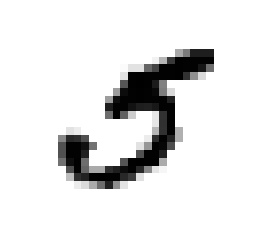

In [9]:
#데이터 셋에서 이미지 하나를 확인해본다.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image =some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [10]:
y[36000]

5.0

In [11]:
# 트레이닝세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
# 훈련세트를 섞어서 모든 교차 검증 폴드가 비슷하게 만듬
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [13]:
# 이진 분류기 훈련 

y_train_5 = (y_train == 5) # 5는 True, 나머지 False
y_test_5 = (y_test == 5)

In [17]:
# 분류 모델을 하나 선택해서 훈련 
# 사이킷런의 SGDClassifier 클래스를 사용해 확률적 경사 하강법 분류기로 시작
# 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지니고 있음 
# 한번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문 // 온라인 학습에 효과적임

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 5, random_state = 42 )
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [19]:
sgd_clf.predict([some_digit])

array([ True])

In [20]:
# 성능 측정
# 교차 검증을 통한 검증
# cross_val_score() 함수사용 폴드가 3개인 k-겹 교차 검증 - 정확도가 3개 다 95% 이상
from sklearn.model_selection  import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9645 , 0.94535, 0.94245])

In [21]:
from sklearn.base import BaseEstimator
# 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기 만듬
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(selt, X):
        return np.zeros((len(X), 1), dtype=bool)

In [22]:
# 정확도가 90%로 딱 맞음 
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9093 , 0.9099 , 0.90975])

In [24]:
# 오차행렬을 조사하기 - 분류기의 성능을 평가하는 더 좋은방법 
# 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는것 
# 예측값을 만들기 
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [25]:
# confusion_matrix 함수를 사용해 오차행렬을 만들기 
# 행은 실제 클래스를 / 열은 예측한 클래스를 나타낸다.
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52628,  1951],
       [ 1003,  4418]])

In [26]:
# ([[진짜음성(5가 아닌 값으로 분류한 아닌 값), 거짓 예측 양성(5라고 분류한 아닌 값)],
#   [거짓 실제 양성(5가 아닌 값으로 분류한 5 값), 진짜양성(5라고 분류한 5 값)]])
# confusion_matrix(y_train_5, y_train_perfect_predictions)


In [29]:
# 요약된 지표 -> 양성 예측의 정확도 ---> 분류기의 정밀도 라고 한다. 
# 정밀도 = TP/(TP+FP) TP = 진짜 양성의 수 FP = 거짓 양성의 수 
# 재현율 = TP/(TP+FN) FN = 거짓 양성의 수 (민감도, 진짜 양성 비율 )

In [30]:
# 정밀도와 재현율 - 분류기의 지표를 계산함
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # 5로 판별된 이미지중 정확도 

0.6936724760558958

In [31]:
recall_score(y_train_5, y_train_pred) # 전체 숫자 5에서 80퍼센트만 감지

0.8149787862018077

In [33]:
# F1점수 -> 정밀도와 재현율을 1개의 숫자로 만들기 " 정밀도와 재현율을 조화평균"
# F1 = 2/((1/정밀도)+(1/재현율)) = 2x(정밀도x재현율)/(정밀도+재현율) // 정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높다.
# fi_score를 사용하여 호출

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

# 상황에 따라 정밀도가 중요할수 있고 재현율이 중요할수도 있다. 정밀도올리면 재현율이 줄고 반대도 마찬가지 >> 정밀도/재현율 트레이드 오프

0.749448685326548

In [ ]:
# 정밀도/재현율 트레이드오프 
